## Import MatPlotLib & Setup

In [23]:
# Setup plotting
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

import seaborn as sns
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

## Import Keras, Pandas & other used libraries

In [24]:
import pandas as pd
import numpy as np

import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.inspection import permutation_importance

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

import shap

## Import Data

In [25]:
df_game_players_normalized_features = pd.read_csv("../data/processed/game_players_normalized_features.csv")

df_game_players_normalized_features_columns = df_game_players_normalized_features.columns

df_game_events = pd.read_csv("../data/game_events.csv")
game_events_features = ['timestamp', 'event_type', 'killer_id', 'killer_name', 'killer_team_id',]

df_game_metadata = pd.read_csv("../data/game_metadata.csv")
game_metadata_features = ['game_id']

df_game_players_stats = pd.read_csv("../data/game_players_stats.csv")

game_players_stats_features_num = ['game_length', 'champion_name', 'tower_kills', 'inhibitor_kills', 'dragon_kills', 'herald_kills', 'baron_kills', 
                               'player_kills', 'player_deaths', 'player_assists','total_minions_killed', 'gold_earned', 'level', 
                               'total_damage_dealt','total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 
                               'largest_killing_spree', 'largest_multi_kill']

game_players_stats_features_by_user_num = ['player_kills', 'player_deaths', 'player_assists', 'total_minions_killed', 'gold_earned', 'level', 
                                            'total_damage_dealt', 'total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 
                                            'largest_killing_spree', 'largest_multi_kill']
game_players_stats_features_by_user_cat = ['champion_name']

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
match_players = df_game_players_stats[df_game_players_stats['game_id'] == 0]

# Get league names
unique_leagues = df_game_metadata['league_name'].unique()

## Import models & tools

In [26]:
import joblib

top_model = keras.models.load_model('role_models/top_model.keras')
jungle_model = keras.models.load_model('role_models/jungle_model.keras')
mid_model = keras.models.load_model('role_models/mid_model.keras')
sup_model = keras.models.load_model('role_models/sup_model.keras')
bot_model = keras.models.load_model('role_models/bot_model.keras')

models_by_role = {
    'Top': top_model,
    'Jungle': jungle_model,
    'Mid': mid_model,
    'Support': sup_model,
    'Bot': bot_model
}

win_loose_preprocessor = joblib.load('tools/win_loose_preprocessor.pkl')

## Import functions

In [27]:
def get_useful_players_data(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Select pre-normalized features instead of computing them"""
    return dataframe[useful_player_columns_num]

def get_solo_player_data(player_id: int, game_id: int) -> pd.DataFrame:
    """
    Get player data for a specific player and game.
    """
    # Filter by game_id first
    df_player = df_game_players_normalized_features[df_game_players_normalized_features['game_id'] == game_id]
    
    # Filter by player_id
    df_player = df_player[df_player['player_id'] == player_id]
    
    # Just select the features - they're already normalized
    df_player_selected = get_useful_players_data(df_player)
    
    return df_player_selected

useful_player_columns_num = ['KLA', 'gold_pm', 'lvl_pm', 'creep_score_pm', 'wards_pm',
                            'damage_pm', 'damage_to_champions_pm', 'damage_taken_pm',
                            'greatest_killing_spree', 'greatest_multi_kill']

player_roles = ['Top', 'Jungle', 'Mid', 'Support', 'Bot']

def group_split(X: pd.DataFrame, y: pd.Series, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

def get_role_data(role: str, test_game_id: int | None = None) -> tuple:
    # X = df_game_players_stats.loc[df_game_players_stats['role'] == role].copy()
    
    # With normalized features:
    X = df_game_players_normalized_features.loc[df_game_players_normalized_features['role'] == role].copy()
    
    if test_game_id is not None:
        X = X.loc[X['game_id'] != test_game_id].copy()
    
    y = X['win'].copy()
    group = X['game_id'].copy()
    
    X = get_useful_players_data(X)
    
    X_train, X_valid, y_train, y_test = group_split(X, y, group)
    
    X_train = win_loose_preprocessor.fit_transform(X_train)
    X_valid = win_loose_preprocessor.transform(X_valid)
    
    return X_train, X_valid, y_train, y_test

## Compute Win probability for each player in each game

In [28]:
def compute_player_win_probabilities(df_players, models_by_role, batch_size=64):
    """
    Compute win probability for each player in each game using role-specific models.
    Optimized for speed with batched predictions.
    
    Args:
        df_players: DataFrame with player stats
        models_by_role: Dictionary of trained models for each role
        batch_size: Number of samples to process at once
    
    Returns:
        DataFrame with player IDs, game IDs, roles, and win probabilities
    """
    # Suppress TensorFlow logging and warnings
    import os
    import logging
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    
    # Dictionary to store predictions by role
    results = []
    role_groups = df_players.groupby('role')
    
    # Process one role at a time
    for role, role_df in role_groups:
        print(f"Processing role: {role}")
        
        if role not in models_by_role:
            continue
            
        model = models_by_role[role]
        
        # Group players by game to enable batch processing
        game_player_groups = role_df.groupby(['player_id', 'game_id'])
        
        # Collect all data for this role
        all_player_ids = []
        all_game_ids = []
        all_preprocessed_data = []
        all_wins = []
        
        for (player_id, game_id), player_data in game_player_groups:
            X_player = get_useful_players_data(player_data)
            X_player_preprocessed = win_loose_preprocessor.transform(X_player)
            
            all_player_ids.append(player_id)
            all_game_ids.append(game_id)
            all_preprocessed_data.append(X_player_preprocessed)
            all_wins.append(player_data['win'].iloc[0])
        
        # If no players for this role, continue
        if not all_preprocessed_data:
            continue
            
        # Convert to appropriate format for batch prediction
        X_batch = np.vstack(all_preprocessed_data)
        
        # Make predictions in batch (much faster!)
        print(f"Processing {len(X_batch)} predictions for role: {role}")
        win_probabilities = model.predict(X_batch, batch_size=batch_size, verbose=0).flatten()
        
        # Store results
        for i in range(len(all_player_ids)):
            results.append({
                'player_id': all_player_ids[i],
                'game_id': all_game_ids[i],
                'role': role,
                'win_probability': win_probabilities[i],
                'actual_outcome': all_wins[i]
            })
    
    return pd.DataFrame(results)

## Compute performance metrics & Normalize them

In [29]:
def calculate_player_performance_metrics(win_probabilities_df):
    """
    Calculate performance metrics for each player across all games.
    
    Args:
        win_probabilities_df: DataFrame with win probabilities
    
    Returns:
        DataFrame with player performance metrics
    """
    # Group by player_id
    player_metrics = []
    
    for player_id, player_games in win_probabilities_df.groupby('player_id'):
        # Calculate metrics
        avg_win_probability = player_games['win_probability'].mean()
        num_games = len(player_games)
        actual_win_rate = player_games['actual_outcome'].mean()
        
        # Calculate "impact score" - how much better the player performs than predicted
        # This could be a measure of clutch performance or consistency
        impact_score = actual_win_rate - avg_win_probability
        
        # Calculate variance in performance
        win_prob_variance = player_games['win_probability'].var()
        
        # Store metrics
        player_metrics.append({
            'player_id': player_id,
            'role': player_games['role'].iloc[0],  # Assuming player always plays same role
            'num_games': num_games,
            'avg_win_probability': avg_win_probability,
            'actual_win_rate': actual_win_rate,
            'impact_score': impact_score,
            'performance_consistency': 1 - win_prob_variance  # Higher is more consistent
        })
    
    return pd.DataFrame(player_metrics)

def normalize_performance_by_role(player_metrics_df):
    """
    Transform performance metrics to percentiles within each role.
    
    Args:
        player_metrics_df: DataFrame with player performance metrics
    
    Returns:
        DataFrame with normalized performance metrics
    """
    normalized_df = player_metrics_df.copy()
    
    # List of metrics to normalize
    metrics_to_normalize = [
        'avg_win_probability', 
        'impact_score', 
        'performance_consistency'
    ]
    
    # Normalize each metric within role
    for role in player_metrics_df['role'].unique():
        role_mask = normalized_df['role'] == role
        role_df = normalized_df[role_mask]
        
        for metric in metrics_to_normalize:
            # Calculate percentile rank for this metric within this role
            percentile_values = role_df[metric].rank(pct=True)
            
            # Update normalized DataFrame
            normalized_df.loc[role_mask, f'{metric}_percentile'] = percentile_values
    
    return normalized_df

## Categorize Leagues by region to compute meta rankings

In [30]:
def categorize_leagues_by_region(df_metadata):
    """
    Categorize each league in the dataset into a geographical region.
    
    Args:
        df_metadata: DataFrame containing league_name column
        
    Returns:
        Dictionary mapping each league to its region and DataFrame with region information
    """
    # Define region mappings (based on common esports regions)
    region_mapping = {
        # Korea
        'LCK': 'Korea',
        'LCK CL': 'Korea',
        'LCK Academy': 'Korea',
        'LCK Challengers League': 'Korea',
        'Challenger Korea': 'Korea',
        'KeSPA Cup': 'Korea',
        
        # China
        'LPL': 'China',
        'LPLOL': 'China',
        'LDL': 'China',
        'Demacia Cup': 'China',
        'NEST': 'China',
        
        # Europe
        'LEC': 'Europe',
        'European Masters': 'Europe',
        'European Pro League': 'Europe',
        'EMEA Masters': 'Europe',
        'LFL': 'Europe',  # French league
        'LFL Division 2': 'Europe',
        'Coupe de France': 'Europe',
        'LVP SL': 'Europe',  # Spanish league
        'LVP SL 2nd Division': 'Europe',
        'Iberian Cup': 'Europe',
        'Prime League 1st Division': 'Europe',  # DACH region
        'Prime League Super Cup': 'Europe',
        'Prime Pokal': 'Europe',
        'Ultraliga': 'Europe',  # Polish league
        'NLC': 'Europe',  # Northern League Championship
        'PG Nationals': 'Europe',  # Italian league
        'Elite Series': 'Europe',  # Benelux
        'Elite Series Benelux Masters': 'Europe',
        'Hitpoint Masters': 'Europe',  # Czech/Slovak
        'Esports Balkan League': 'Europe',
        'EBL': 'Europe',  # Esports Balkan League
        'TCL': 'Europe',  # Turkey
        'TCL Division 2': 'Europe',
        'Baltic Masters': 'Europe',
        'Belgian League': 'Europe',
        'Dutch League': 'Europe',
        'Elements League': 'Europe',
        'GLL': 'Europe',  # Greek League
        'LHE': 'Europe',  # Hellenic League
        'LIT': 'Europe',  # Italian League
        'LMF': 'Europe',  # French Minor League
        'DDH': 'Europe',  # German Division
        'Ignis Cup': 'Europe',
        
        # Japan
        'LJL': 'Japan',
        
        # North America
        'LCS': 'North America',
        'LCS Academy': 'North America',
        'LCS Proving Grounds': 'North America',
        'North American Challengers League': 'North America',  # NACL
        'Americas Challengers': 'North America',
        
        # South America
        'LLA': 'Latin America',  # Latin America
        
        # Brazil
        'CBLOL': 'Brazil',  # Brazil
        'CBLOL Academy': 'Brazil',
        
        # Asia Pacific
        'PCS': 'Asia Pacific',  # Pacific Championship Series
        'OPL': 'Asia Pacific',  # Oceanic Pro League
        'LCO': 'Asia Pacific',  # League of Legends Circuit Oceania
        
        # Vietnam
        'VCS': 'Vietnam',  # Vietnam Championship Series
        
        # Other regions
        'LCL': 'CIS',  # Commonwealth of Independent States = Russia and surrounding countries
        'Arabian League': 'Middle East',
        
        # International events
        'Worlds': 'International',
        'Mid-Season Invitational': 'International',
        'All-Star': 'International',
        'Season Kickoff': 'International',
        'Mid-Season Cup': 'International',
        'Esports World Cup': 'International',
        'Superdome': 'International',
        'Karmine Corp vs Ibai Showmatch': 'International',
        'Red Bull League of Its Own': 'International'
    }
    
    # Get unique leagues
    leagues = df_metadata['league_name'].unique()
    
    # Create a dictionary to store leagues by region
    leagues_by_region = {
        'Korea': [],
        'China': [],
        'Europe': [],
        'North America': [],
        'Latin America': [],
        'Brazil': [],
        'Asia Pacific': [],
        'Vietnam': [],
        'Japan': [],
        'Middle East': [],
        'CIS': [],
        'International': [],
        'Others': []
    }
    
    # Categorize each league
    for league in leagues:
        if league in region_mapping:
            region = region_mapping[league]
            # Add to the specific region
            if region in leagues_by_region:
                leagues_by_region[region].append(league)
            else:
                # For regions we didn't explicitly list as categories
                leagues_by_region['Others'].append(league)
        else:
            # If we don't have a mapping, put it in Others
            leagues_by_region['Others'].append(league)
    
    # Create DataFrame with league to region mapping
    league_region_df = pd.DataFrame({
        'league_name': [league for region in leagues_by_region.values() 
                      for league in region],
        'region': [region for region, leagues in leagues_by_region.items() 
                 for _ in range(len(leagues))]
    })
    
    return leagues_by_region, league_region_df

leagues_by_region, league_region_df = categorize_leagues_by_region(df_game_metadata)


## Add regional strength factors to represent real world rankings

In [31]:
def compute_region_strength_factors(df_game_players_stats, df_game_metadata, league_region_df, verbose=False):
    """
    We compute the strength of each region based on international game results.
    This function identifies the primary region for each team based on their game history,
    and then analyzes the results of international games to compute a strength factor for each region.
    The baseline weights are predefined for each region and originate from the PandaSkill study.
    """
    # First, identify teams' home regions
    # For each team, find where they play most of their games (excluding international events)
    team_regions = {}
    
    # Merge to get league and region info
    df_player_games = df_game_players_stats.merge(
        df_game_metadata[['game_id', 'league_name', 'date']], 
        on='game_id'
    ).merge(
        league_region_df, 
        on='league_name'
    )
    
    # Group by team, count games in each region (excluding international)
    team_region_counts = df_player_games[df_player_games['region'] != 'International'] \
        .groupby(['team_id', 'region']).size().reset_index(name='games')
    
    # Get primary region for each team
    for team_id, team_data in team_region_counts.groupby('team_id'):
        if not team_data.empty:
            # Get region where team played most games
            primary_region = team_data.loc[team_data['games'].idxmax(), 'region']
            team_regions[team_id] = primary_region
    
    # Now identify international games
    international_games = df_player_games[df_player_games['region'] == 'International']
    
    # Process international results with team's actual regions
    international_results = []
    nbr_international_games = 0
    
    for game_id, game_data in international_games.groupby('game_id'):
        # Get the two teams in this game
        teams = game_data['team_id'].unique()
        if len(teams) == 2:
            # Get winner
            winning_team = game_data[game_data['win'] == True]['team_id'].iloc[0]
            losing_team = teams[0] if teams[0] != winning_team else teams[1]
            
            # Use pre-computed team regions
            winner_region = team_regions.get(winning_team)
            loser_region = team_regions.get(losing_team)
            
            # Record result if both teams have known regions and different regions
            if winner_region and loser_region and winner_region != loser_region:
                nbr_international_games += 1
                international_results.append({
                    'winning_region': winner_region,
                    'losing_region': loser_region,
                    'date': game_data['date'].iloc[0]
                })
    
    if verbose:
        print(f"Number of international games: {nbr_international_games}")                    
    
    region_stats = {}
    # Modified region strength baseline weights based on PandaSkill paper
    baseline_weights = {
        'Korea': 1.20,    # Strongest region consistently
        'China': 1.15,    # Second strongest region 
        'Europe': 1.05,    # Third strongest region
        'North America': 0.95,  # Fourth tier
        'Vietnam': 0.92,
        'Asia Pacific': 0.90,
        'Brazil': 0.88,
        'Latin America': 0.85,  # Generally weakest major region
        'Japan': 0.88,     # Minor regions - less data but generally below major regions
        'CIS': 0.87,
        'Middle East': 0.85,
        'International': 1.00,  # Neutral value for international (shouldn't affect)
        'Others': 0.85
    }
    
    # Calculate win rates by region
    if international_results:
        region_wins = {}
        region_losses = {}
        region_matches = {}
        
        for result in international_results:
            winner = result['winning_region']
            loser = result['losing_region']
            
            # Update wins
            region_wins[winner] = region_wins.get(winner, 0) + 1
            # Update losses
            region_losses[loser] = region_losses.get(loser, 0) + 1
            # Update match counts
            region_matches[winner] = region_matches.get(winner, 0) + 1
            region_matches[loser] = region_matches.get(loser, 0) + 1
        
        # Calculate win rates with Bayesian smoothing for regions with few games
        smoothing_factor = 5  # Prevents extreme values for regions with few games
        
        for region in set(region_matches.keys()):
            wins = region_wins.get(region, 0)
            matches = region_matches.get(region, 0)
            
            # Bayesian win rate (with prior of 0.5)
            win_rate = (wins + (smoothing_factor * 0.5)) / (matches + smoothing_factor)
            
            # Calculate strength modifier (centered around 1.0)
            strength_modifier = 0.5 + win_rate
            
            # Update region stats
            region_stats[region] = {
                'wins': wins,
                'matches': matches,
                'win_rate': win_rate,
                'strength_modifier': strength_modifier
            }
    
    final_strength = {}
    # Calculate final strength for each region and add a confidence factor
    for region, baseline in baseline_weights.items():
        if region in region_stats:
            # Calculate confidence based on number of matches
            matches = region_stats[region]['matches']
            confidence = min(matches / 50.0, 1.0)  # Full confidence at 50+ matches

            # Blend computed and baseline with confidence-based weighting
            computed = region_stats[region]['strength_modifier']
            final_strength[region] = confidence * computed + (1 - confidence) * baseline
        else:
            final_strength[region] = baseline
    
    # Normalize to keep Korea at the top reference point
    max_strength = max(final_strength.values())
    reference_strength = 1.20  # Maximum desired strength value
    
    for region in final_strength:
        final_strength[region] = (final_strength[region] / max_strength) * reference_strength
    
    return final_strength

## Compute region meta ranking

In [32]:
def compute_region_meta_ranking(normalized_metrics_df, df_game_metadata, league_region_df):
    """
    Compute a meta ranking for players based on their region with dynamic strength factors.
    """
    # First, add the league information to each player's games
    df_player_leagues = df_game_players_stats[['player_id', 'game_id']].merge(
        df_game_metadata[['game_id', 'league_name']], 
        on='game_id'
    )
    
    # Add region information
    df_player_regions = df_player_leagues.merge(league_region_df, on='league_name')
    
    # Get the primary region for each player (most common region they played in)
    player_regions = df_player_regions.groupby('player_id')['region'].agg(
        lambda x: x.value_counts().index[0]
    ).reset_index()
    
    # Add region to normalized metrics
    df_with_regions = normalized_metrics_df.merge(player_regions, on='player_id', how='left')
    
    # Get dynamic regional strength factors
    region_strength = compute_region_strength_factors(
        df_game_players_stats, df_game_metadata, league_region_df
    )
    
    # Add region strength to player data
    df_with_regions['region_strength'] = df_with_regions['region'].map(region_strength).fillna(0.9)
    
    # Calculate region-specific metrics with strength adjustment
    region_metrics = {}
    for region in df_with_regions['region'].unique():
        if pd.isna(region):
            continue
            
        region_df = df_with_regions[df_with_regions['region'] == region]
        region_strength_value = region_strength.get(region, 1.0)
        
        # Calculate metrics for each role within region
        for role in region_df['role'].unique():
            role_region_df = region_df[region_df['role'] == role]
            
            # Need minimum number of players for meaningful percentiles
            if len(role_region_df) < 5:
                continue
                
            # Calculate regional percentile ranks with strength adjustment
            for metric in ['avg_win_probability', 'impact_score', 'performance_consistency']:
                # Adjust values by region strength before ranking
                adjusted_values = role_region_df[metric] * region_strength_value
                percentile_values = adjusted_values.rank(pct=True)
                
                region_key = f"{region}_{role}"
                if region_key not in region_metrics:
                    region_metrics[region_key] = {}
                    
                region_metrics[region_key][metric] = dict(zip(role_region_df['player_id'], percentile_values))
    
    # Add region meta percentiles to player data
    df_with_regions['region_win_prob_percentile'] = None
    df_with_regions['region_impact_percentile'] = None
    df_with_regions['region_consistency_percentile'] = None
    
    for idx, row in df_with_regions.iterrows():
        region_key = f"{row['region']}_{row['role']}"
        if region_key in region_metrics:
            player_id = row['player_id']
            
            metrics = region_metrics[region_key]
            if player_id in metrics.get('avg_win_probability', {}):
                df_with_regions.at[idx, 'region_win_prob_percentile'] = metrics['avg_win_probability'][player_id]
                
            if player_id in metrics.get('impact_score', {}):
                df_with_regions.at[idx, 'region_impact_percentile'] = metrics['impact_score'][player_id]
                
            if player_id in metrics.get('performance_consistency', {}):
                df_with_regions.at[idx, 'region_consistency_percentile'] = metrics['performance_consistency'][player_id]
    
    # Calculate overall region meta score (for players with enough data)
    valid_mask = df_with_regions['region_win_prob_percentile'].notnull()
    df_with_regions['region_meta_score'] = None
    
    # Use numpy to avoid the type warning
    if valid_mask.any():
        win_prob = df_with_regions.loc[valid_mask, 'region_win_prob_percentile'].to_numpy() * 0.4
        impact = df_with_regions.loc[valid_mask, 'region_impact_percentile'].to_numpy() * 0.3
        consistency = df_with_regions.loc[valid_mask, 'region_consistency_percentile'].to_numpy() * 0.3
        
        df_with_regions.loc[valid_mask, 'region_meta_score'] = win_prob + impact + consistency
    
    return df_with_regions


region_strength = compute_region_strength_factors(df_game_players_stats, df_game_metadata, league_region_df, verbose=True)
print("Region Strength Factors:")
for region, strength in region_strength.items():
    print(f"{region}: {strength:.2f}")

Number of international games: 843
Region Strength Factors:
Korea: 1.20
China: 1.16
Europe: 0.95
North America: 0.93
Vietnam: 0.86
Asia Pacific: 0.91
Brazil: 0.84
Latin America: 0.73
Japan: 0.82
CIS: 0.87
Middle East: 0.90
International: 1.01
Others: 0.86


This methodology is useful in our situation, because it represents the difference of player skill in the real world. But the computation could have been avoided because we still base our baseline weights on the skill rankings of PandaSkill & also because the number of games played between different regions is quite low (843), so it is not very representative.

## Compute Skill rank

In [33]:
def compute_enhanced_skill_rank(normalized_metrics_df, df_game_metadata, league_region_df, weights=None, min_games=5, use_region_adjustment=True):
    """
    Compute enhanced skill rank incorporating region meta rankings with improved 
    handling of regional strength differences.
    
    Args:
        normalized_metrics_df: DataFrame with normalized metrics
        df_game_metadata: DataFrame with game metadata
        league_region_df: DataFrame mapping leagues to regions
        weights: Optional dictionary of weights for metrics
        min_games: Minimum number of games required for ranking
        
    Returns:
        DataFrame with enhanced player skills and ranks
    """
    # Filter by minimum game count
    filtered_df = normalized_metrics_df[normalized_metrics_df['num_games'] >= min_games].copy()
    
    # Get region meta rankings with strength factors
    region_df = compute_region_meta_ranking(filtered_df, df_game_metadata, league_region_df)
    
    if weights is None:
        weights = {
            'avg_win_probability_percentile': 0.30,
            'impact_score_percentile': 0.30, 
            'performance_consistency_percentile': 0.20,
            'region_meta_score': 0.20 
        }
    
    # Calculate reliability factor - more games = more reliable data
    # Using exponential growth function similar to paper's approach
    region_df['reliability'] = 1 - np.exp(-0.1 * region_df['num_games'])
    
    # Initialize skill score column
    region_df['skill_score'] = 0.0  
    
    # Add global metrics with exponential weighting to emphasize exceptional performance
    for metric in ['avg_win_probability_percentile', 'impact_score_percentile', 'performance_consistency_percentile']:
        if metric in weights:
            # Apply element-wise multiplication with non-linear scaling
            region_df['skill_score'] += (
                region_df[metric] * weights[metric] * region_df['reliability']
            )
    
    # Add region meta score if available with regional strength consideration
    if 'region_meta_score' in weights:
        has_region = region_df['region_meta_score'].notnull()
        
        if has_region.any():
            # Add the regional component with explicit conversion to float
            region_df.loc[has_region, 'skill_score'] += (
                region_df.loc[has_region, 'region_meta_score'].astype(float) * 
                weights['region_meta_score'] * 
                region_df.loc[has_region, 'reliability']
            )
            
            # For players without region data, redistribute region weight
            if (~has_region).any():
                region_weight = weights['region_meta_score']
                remaining_weight = sum(weights.values()) - region_weight
                
                for metric in ['avg_win_probability_percentile', 'impact_score_percentile', 'performance_consistency_percentile']:
                    if metric in weights:
                        extra_weight = weights[metric] / remaining_weight * region_weight
                        region_df.loc[~has_region, 'skill_score'] += (
                            region_df.loc[~has_region, metric] * 
                            extra_weight * 
                            region_df.loc[~has_region, 'reliability']
                        )
                        
        if not use_region_adjustment in weights:
            # Redistribute region weight to other metrics
            region_weight = weights.pop('region_meta_score')
            remaining_sum = sum(weights.values())
            for metric in weights:
                weights[metric] += (weights[metric] / remaining_sum) * region_weight
            
    # Calculate overall rank
    region_df['skill_rank'] = region_df['skill_score'].rank(ascending=False)
    
    # Add player names
    player_names = df_game_players_stats[['player_id', 'player_name']].drop_duplicates()
    region_df = region_df.merge(player_names, on='player_id')
    
    return region_df.sort_values('skill_rank')

## Generate win probabilities

In [34]:
# Generate win probabilities with a larger batch size for speed
print("Starting win probability calculations...")

# df_win_probs = compute_player_win_probabilities(df_game_players_stats, models_by_role, batch_size=15000)

# Get the win probabilities for the normalized features
df_win_probs = compute_player_win_probabilities(df_game_players_normalized_features, models_by_role, batch_size=15000)

print(f"Finished processing {len(df_win_probs)} player predictions")

Starting win probability calculations...
Processing role: Bot
Processing 74089 predictions for role: Bot
Processing role: Jungle
Processing 73846 predictions for role: Jungle
Processing role: Mid
Processing 73896 predictions for role: Mid
Processing role: Support
Processing 73963 predictions for role: Support
Processing role: Top
Processing 73980 predictions for role: Top
Finished processing 369774 player predictions


## Save probabilities

In [35]:

def save_proba():
    os.makedirs('computed_dataframe/', exist_ok=True)
    df_win_probs.to_csv('computed_dataframe/win_probabilities.csv', index=False)
    
save_proba()

## Import CSV already computed (18min with RTX 3060)

In [36]:
df_win_probs = pd.read_csv('computed_dataframe/win_probabilities.csv')

## Generate performance

In [37]:
df_performance_metrics = calculate_player_performance_metrics(df_win_probs)

df_normalized_metrics = normalize_performance_by_role(df_performance_metrics)

## Generate Skill rankings

In [38]:
# Display enhanced rankings with region and meta score
enhanced_rankings = compute_enhanced_skill_rank(df_normalized_metrics, df_game_metadata, league_region_df, use_region_adjustment=False)

# Create a formatted display function
def display_enhanced_rankings(rankings, top_n=40):
    """
    Display enhanced rankings with clear region and meta score information.
    """
    display_cols = [
        'skill_rank', 'player_name', 'role', 'region', 
        'region_strength', 'region_meta_score', 'skill_score', 
        'num_games', 'avg_win_probability', 'actual_win_rate'
    ]
    
    # Format the output
    display_df = rankings[display_cols].head(top_n).copy()
    
    # Add rank column prefix
    display_df['skill_rank'] = display_df['skill_rank'].apply(lambda x: f"#{int(x)}")
    
    # Format percentages
    for col in ['skill_score', 'avg_win_probability', 'actual_win_rate', 'region_meta_score']:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.3f}" if pd.notnull(x) else "N/A")
            
    # Format region strength
    if 'region_strength' in display_df.columns:
        display_df['region_strength'] = display_df['region_strength'].apply(
            lambda x: f"{x:.2f}x" if pd.notnull(x) else "N/A"
        )
    
    return display_df.set_index('skill_rank')

# Display top players with enhanced format
display_enhanced_rankings(enhanced_rankings)

,player_name,role,region,region_strength,region_meta_score,skill_score,num_games,avg_win_probability,actual_win_rate
skill_rank,,,,,,,,,
#1,Nanaue,Top,Vietnam,0.86x,0.965,0.941,42,0.630,0.738
#2,LYONZ,Bot,Latin America,0.73x,0.931,0.928,188,0.648,0.713
#3,Clever9,Top,China,1.16x,0.939,0.927,43,0.646,0.721
#4,Qats,Mid,Brazil,0.84x,0.916,0.918,161,0.609,0.677
#5,JDG,Top,Europe,0.95x,0.908,0.913,64,0.637,0.719
#6,jiang,Bot,China,1.16x,0.893,0.911,128,0.657,0.727
#7,Putin,Top,Europe,0.95x,0.945,0.908,38,0.869,0.895
#8,Snow,Bot,China,1.16x,0.922,0.906,61,0.824,0.852
#9,Nerzhul,Support,Europe,0.95x,0.946,0.904,34,0.748,0.853


## Visualize skill rankings

C:\Users\arthu\AppData\Local\Temp\ipykernel_27576\2946341948.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  top_players['other_contribution'] = top_players['skill_score'] - top_players['meta_contribution'].fillna(0)


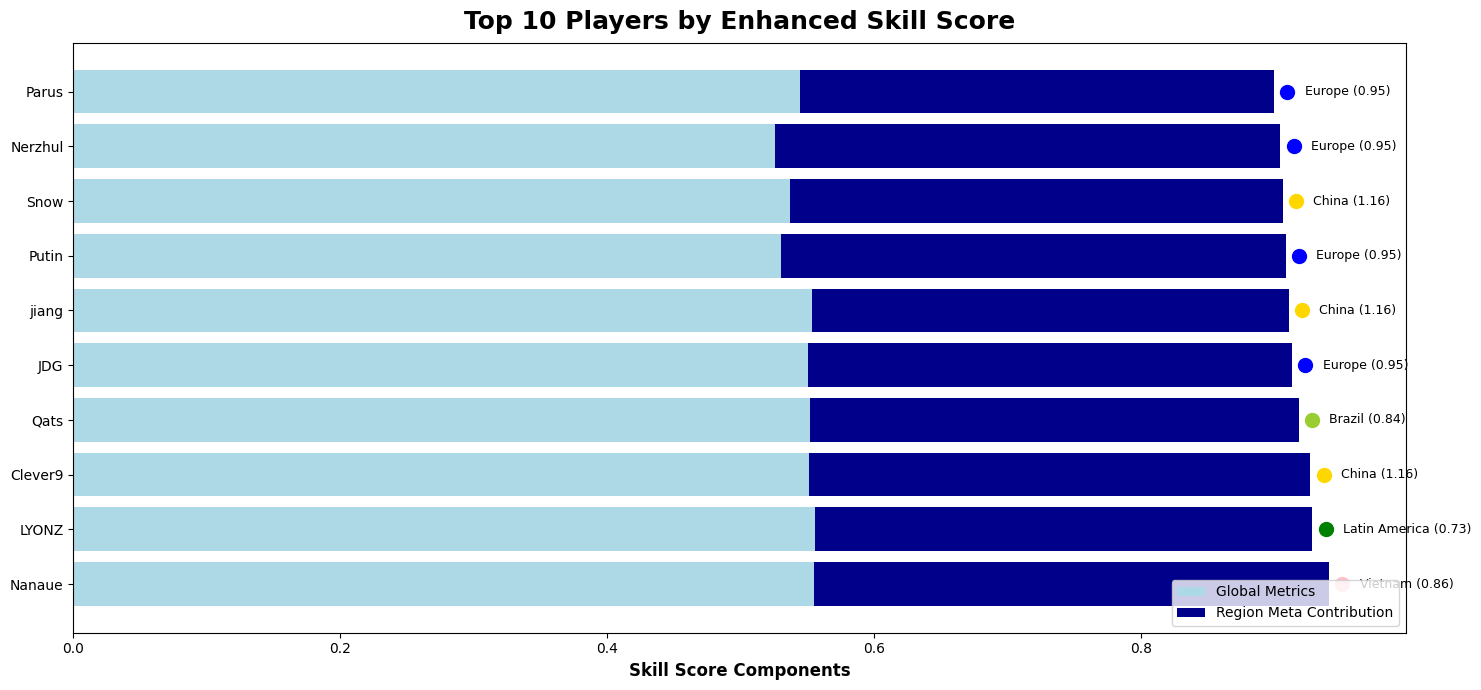

In [39]:
def visualize_enhanced_rankings_with_meta(rankings):
    """
    Create visualizations of enhanced player rankings showing meta score contribution.
    """
    # Top players overall
    top_players = rankings.sort_values('skill_score', ascending=False).head(10)
    
    plt.figure(figsize=(15, 7))
    
    # Calculate the meta score contribution vs other components
    top_players['meta_contribution'] = top_players['region_meta_score'] * 0.4  # Updated weight
    top_players['other_contribution'] = top_players['skill_score'] - top_players['meta_contribution'].fillna(0)
    
    # Create stacked bars
    y_pos = range(len(top_players))
    plt.barh(y_pos, top_players['other_contribution'], color='lightblue', label='Global Metrics')
    plt.barh(y_pos, top_players['meta_contribution'], left=top_players['other_contribution'], 
             color='darkblue', label='Region Meta Contribution')
    
    # Add region markers with better visibility
    region_colors = {
        'Korea': 'red',
        'China': 'gold',
        'Europe': 'blue',
        'North America': 'teal',
        'Latin America': 'green',
        'Brazil': 'yellowgreen',
        'Asia Pacific': 'purple',
        'Vietnam': 'pink',
        'Japan': 'orange',
        'International': 'gray',
        'Middle East': 'brown',
        'CIS': 'cyan'
    }
    
    for i, (_, player) in enumerate(top_players.iterrows()):
        region = player['region']
        if pd.notna(region):
            plt.plot(player['skill_score'] + 0.01, i, 'o', 
                     color=region_colors.get(region, 'black'), 
                     markersize=10)
            plt.text(player['skill_score'] + 0.02, i, 
                    f" {region} ({player['region_strength']:.2f})", 
                    va='center', fontsize=9)
    
    plt.yticks(y_pos, top_players['player_name'])
    plt.xlabel('Skill Score Components')
    plt.title('Top 10 Players by Enhanced Skill Score')
    plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

# Visualize with enhanced meta score contributions
visualize_enhanced_rankings_with_meta(enhanced_rankings)

## Extract most unusual data from top players

What distinguishes top 100 players from average players?

Metrics where top players exceed the average by the largest percentages:


,mean,overall_mean,percent_higher
num_games,192.380,98.423,95.463
avg_win_probability_percentile,0.942,0.501,88.213
impact_score_percentile,0.866,0.501,72.912
actual_win_rate,0.687,0.425,61.609
avg_win_probability,0.632,0.433,46.024
performance_consistency_percentile,0.705,0.501,40.757
reliability,0.989,0.932,6.132
performance_consistency,0.844,0.839,0.573
impact_score,0.055,-0.008,-828.363



Role distribution among top 100 players:


role
Bot        28.0
Mid        23.0
Top        21.0
Jungle     20.0
Support     8.0
Name: count, dtype: float64


Region distribution among top 100 players:


region
Europe           35.0
Korea            16.0
China            14.0
Asia Pacific      7.0
Brazil            6.0
Latin America     5.0
Vietnam           5.0
North America     5.0
Japan             4.0
Middle East       2.0
CIS               1.0
Name: count, dtype: float64


Correlation between number of games played and skill rank: 0.301

Outliers in specific metrics (number of players > 2 standard deviations above mean):
- avg_win_probability: 11 players
- impact_score: 6 players
- performance_consistency: 2 players
- num_games: 23 players
- actual_win_rate: 13 players

Players exceptional in multiple metrics:
- exceptional_in_1+_metrics: 93 players
- exceptional_in_2+_metrics: 78 players
- exceptional_in_3+_metrics: 67 players
- exceptional_in_4+_metrics: 30 players
- exceptional_in_5+_metrics: 6 players
- exceptional_in_6+_metrics: 1 players
- exceptional_in_7+_metrics: 0 players
- exceptional_in_8+_metrics: 0 players
- exceptional_in_9+_metrics: 0 players


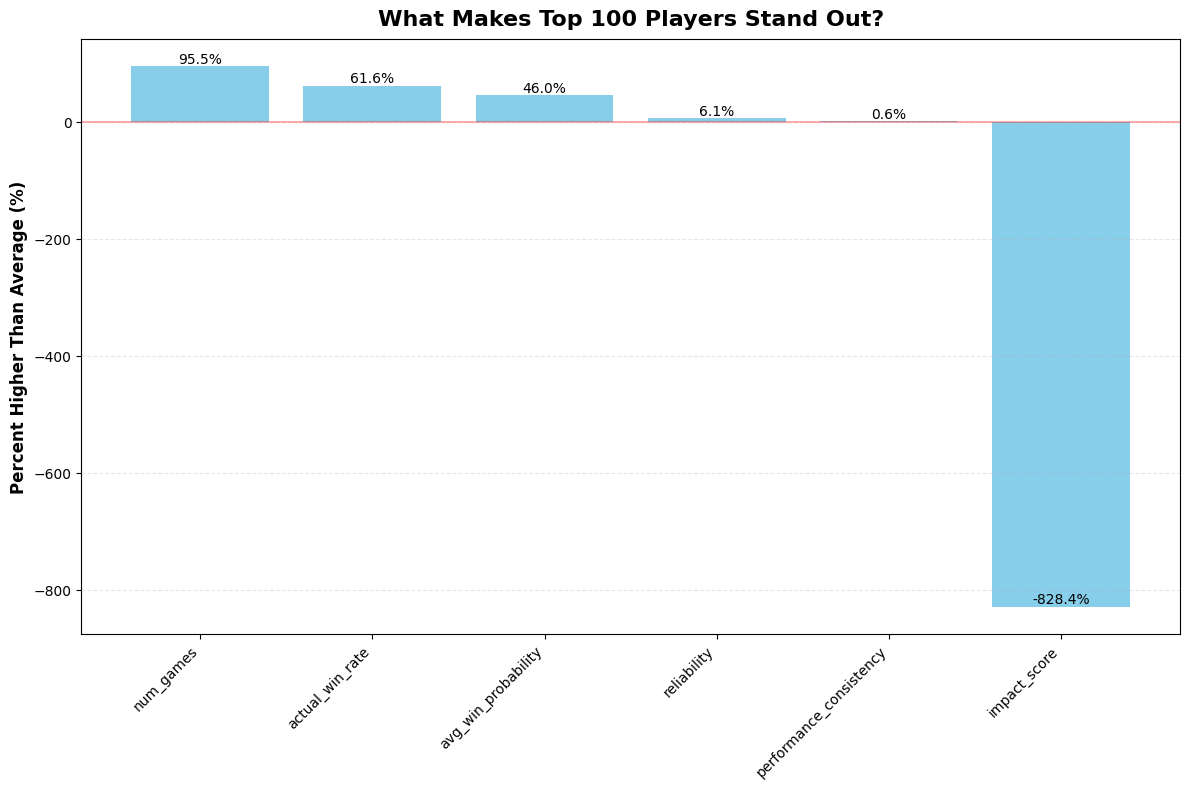

In [40]:
def analyze_top_players_characteristics(enhanced_rankings, top_n=100):
    """
    Analyze what attributes are most common among the top players in the skill rankings.
    This focuses only on data directly used in the skill ranking computation.
    
    Args:
        enhanced_rankings: DataFrame with player skill rankings
        top_n: Number of top players to analyze (default 100)
        
    Returns:
        Analysis of top players' characteristics
    """
    # Get the top players
    top_players = enhanced_rankings.sort_values('skill_rank').head(top_n).copy()
    
    # These are the metrics directly used in skill score calculation
    direct_metrics = [
        'avg_win_probability', 'avg_win_probability_percentile',
        'impact_score', 'impact_score_percentile',  
        'performance_consistency', 'performance_consistency_percentile',
        'num_games', 'reliability', 'actual_win_rate'
    ]
    
    # Only keep columns that exist in the dataframe
    analysis_metrics = [col for col in direct_metrics if col in top_players.columns]
    
    # Calculate stats for these metrics
    metric_stats = top_players[analysis_metrics].describe().T
    
    # Compare to overall population
    overall_means = enhanced_rankings[analysis_metrics].mean()
    metric_stats['overall_mean'] = overall_means
    metric_stats['difference'] = metric_stats['mean'] - overall_means
    metric_stats['percent_higher'] = (metric_stats['difference'] / overall_means * 100)
    
    # Find which metrics have the largest differences for top players
    diff_sorted = metric_stats.sort_values('percent_higher', ascending=False)
    
    # Check role and region distribution in top players
    role_counts = top_players['role'].value_counts()
    role_percent = role_counts / role_counts.sum() * 100
    
    region_counts = top_players['region'].value_counts()
    region_percent = region_counts / region_counts.sum() * 100
    
    # Look at the relationship between games played and ranking
    games_corr = top_players[['skill_rank', 'num_games']].corr().iloc[0, 1]
    
    # Find extreme outliers (players whose metrics are far above average)
    outliers = {}
    for metric in analysis_metrics:
        if metric in top_players.columns:
            # Find players more than 2 standard deviations above mean
            metric_mean = enhanced_rankings[metric].mean()
            metric_std = enhanced_rankings[metric].std()
            outlier_players = top_players[top_players[metric] > metric_mean + 2*metric_std]
            
            if not outlier_players.empty:
                outliers[metric] = len(outlier_players)
    
    # Count how many players are exceptional in multiple metrics
    exceptional_count = {}
    for i in range(1, len(analysis_metrics) + 1):
        count = 0
        for _, player in top_players.iterrows():
            exceptional_metrics = 0
            for metric in analysis_metrics:
                if metric in top_players.columns:
                    metric_mean = enhanced_rankings[metric].mean()
                    metric_std = enhanced_rankings[metric].std()
                    if player[metric] > metric_mean + 1.5*metric_std:
                        exceptional_metrics += 1
            if exceptional_metrics >= i:
                count += 1
        exceptional_count[f'exceptional_in_{i}+_metrics'] = count
    
    return {
        'metric_comparisons': diff_sorted,
        'role_distribution': role_percent,
        'region_distribution': region_percent,
        'games_rank_correlation': games_corr,
        'metric_outliers': outliers,
        'multi_metric_excellence': exceptional_count
    }

# Run the analysis
top_analysis = analyze_top_players_characteristics(enhanced_rankings, top_n=100)

# Display the results
print("What distinguishes top 100 players from average players?")
print("=" * 60)
print("\nMetrics where top players exceed the average by the largest percentages:")
display(top_analysis['metric_comparisons'][['mean', 'overall_mean', 'percent_higher']].sort_values('percent_higher', ascending=False))

print("\nRole distribution among top 100 players:")
display(top_analysis['role_distribution'].sort_values(ascending=False))

print("\nRegion distribution among top 100 players:")
display(top_analysis['region_distribution'].sort_values(ascending=False))

print(f"\nCorrelation between number of games played and skill rank: {top_analysis['games_rank_correlation']:.3f}")

print("\nOutliers in specific metrics (number of players > 2 standard deviations above mean):")
for metric, count in top_analysis['metric_outliers'].items():
    print(f"- {metric}: {count} players")

print("\nPlayers exceptional in multiple metrics:")
for metric, count in top_analysis['multi_metric_excellence'].items():
    print(f"- {metric}: {count} players")

# Create visualization of key differences
plt.figure(figsize=(12, 8))
metric_diff = top_analysis['metric_comparisons'].sort_values('percent_higher', ascending=False)
metrics = [m for m in metric_diff.index if not m.endswith('percentile')][:6]  # Filter out percentile metrics
values = [metric_diff.loc[m, 'percent_higher'] for m in metrics]

bars = plt.bar(metrics, values, color='skyblue')
plt.axhline(y=0, color='red', linestyle='-', alpha=0.3)
plt.ylabel('Percent Higher Than Average (%)')
plt.title('What Makes Top 100 Players Stand Out?', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

This shows that the impact score is our main skill ranking factor when differentiating players, and close second is the number of games (this comes from the baysian approach).

We can also point out that the win rate is above average, so our skill ranking is at least part true in our methodology (but only on a region level, to be sure about it we should check it in more depth, it could also mean that our top ranking players are in good teams on average).

But we need to remember that the impact score is itself a product of the winrate.

## Show average player level per region

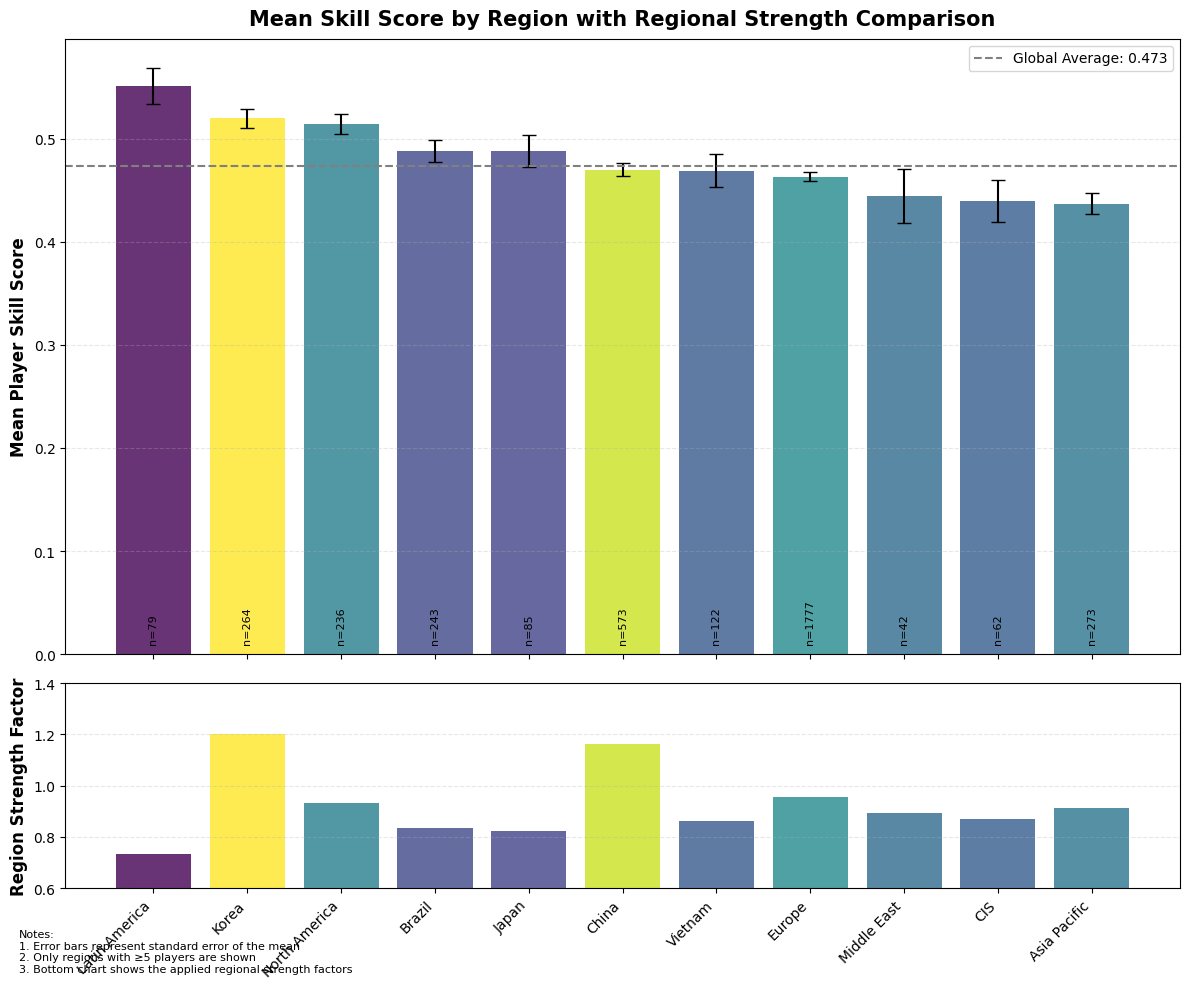


Regional Skill Statistics:
           region  mean_skill  player_count  region_strength
8   Latin America       0.551            79            0.733
7           Korea       0.520           264            1.200
10  North America       0.514           236            0.932
1          Brazil       0.488           243            0.836
6           Japan       0.488            85            0.824
3           China       0.470           573            1.163
11        Vietnam       0.469           122            0.864
4          Europe       0.463          1777            0.954
9     Middle East       0.444            42            0.895
2             CIS       0.440            62            0.870
0    Asia Pacific       0.437           273            0.913


In [41]:
def visualize_skill_by_region(rankings):
    """
    Create a bar chart showing the mean skill score by region.
    
    Args:
        rankings: DataFrame with player rankings including region and skill_score
    """
    # Group by region and calculate mean skill score
    region_stats = rankings.groupby('region').agg({
        'skill_score': ['mean', 'count', 'std'],
        'region_strength': 'mean'
    }).reset_index()
    
    # Flatten the multi-index columns
    region_stats.columns = ['region', 'mean_skill', 'player_count', 'skill_std', 'region_strength']
    
    # Sort by mean skill in descending order
    region_stats = region_stats.sort_values('mean_skill', ascending=False)
    
    # Filter out regions with too few players for statistical significance
    min_players = 5
    region_stats = region_stats[region_stats['player_count'] >= min_players]
    
    # Create figure with two subplots sharing x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, 
                                   gridspec_kw={'height_ratios': [3, 1]})
    
    # Color map based on region strength
    norm = plt.Normalize(region_stats['region_strength'].min(), region_stats['region_strength'].max())
    colors = plt.cm.viridis(norm(region_stats['region_strength']))
    
    # Create main bar chart with error bars
    bars = ax1.bar(region_stats['region'], region_stats['mean_skill'], 
                  yerr=region_stats['skill_std']/np.sqrt(region_stats['player_count']),
                  capsize=5, color=colors, alpha=0.8)
    
    # Add reference line for global average
    global_avg = rankings['skill_score'].mean()
    ax1.axhline(y=global_avg, color='gray', linestyle='--', 
               label=f'Global Average: {global_avg:.3f}')
    
    # Add region strength values on second subplot
    ax2.bar(region_stats['region'], region_stats['region_strength'], 
           color=colors, alpha=0.8)
    ax2.set_ylim(0.6, 1.4)
    ax2.set_ylabel('Region Strength Factor')
    ax2.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add player count as text on bars
    for bar, count in zip(bars, region_stats['player_count']):
        ax1.text(bar.get_x() + bar.get_width()/2, 0.01, 
                f'n={count}', ha='center', va='bottom',
                fontsize=8, rotation=90, color='black')
    
    # Customize main plot
    ax1.set_ylabel('Mean Player Skill Score')
    ax1.set_title('Mean Skill Score by Region with Regional Strength Comparison', 
                 fontsize=15, fontweight='bold')
    ax1.grid(axis='y', linestyle='--', alpha=0.3)
    ax1.legend()
    
    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add explanatory text
    fig.text(0.02, 0.02, 
            "Notes:\n"
            "1. Error bars represent standard error of the mean\n"
            "2. Only regions with ≥5 players are shown\n"
            "3. Bottom chart shows the applied regional strength factors",
            fontsize=8, va='bottom')
    
    plt.show()
    
    return region_stats

# Generate and show the visualization
region_skill_stats = visualize_skill_by_region(enhanced_rankings)

# Display the numerical data as well
pd.set_option('display.precision', 3)
print("\nRegional Skill Statistics:")
print(region_skill_stats[['region', 'mean_skill', 'player_count', 'region_strength']]
      .sort_values('mean_skill', ascending=False))

By comparing this list to the data PandaSkill achieved we are quite away from having an accurate ranking system, our first hypothesis for this error is the number of players in the odd regions being quite low (especially latin america), also their is a bias in our skill ranking system with the number of played games (this can lead to bad players having a high number of played games being high in the ranking).

## Analyzing feature importance by player role

Most Important Raw Statistics By Player Role
----------------------------------------------------------------------


C:\Users\arthu\AppData\Local\Temp\ipykernel_27576\1612133590.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  styled_table['Correlation with Skill'] = styled_table['Correlation with Skill'].apply(lambda x: f'{x:.3f}')


,Role,Most Important Stat,Correlation with Skill,Top 3 Stats
0,Top,KLA,0.796,"[KLA, greatest_killing_spree, gold_pm]"
1,Bot,KLA,0.820,"[KLA, greatest_killing_spree, gold_pm]"
2,Mid,KLA,0.792,"[KLA, greatest_killing_spree, gold_pm]"
3,Support,KLA,0.775,"[KLA, gold_pm, wards_pm]"
4,Jungle,KLA,0.815,"[KLA, greatest_killing_spree, gold_pm]"


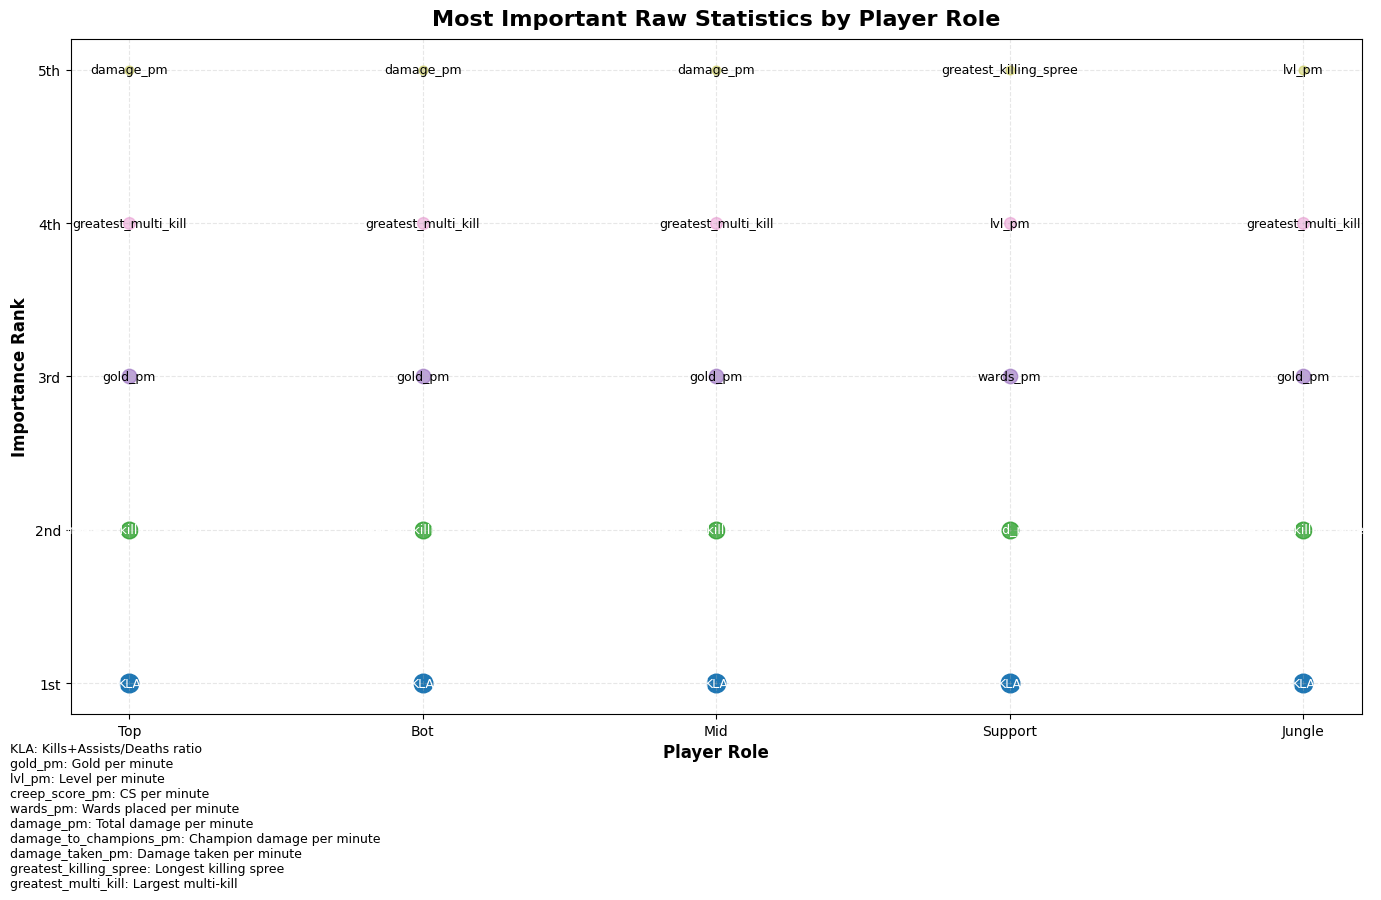


Average Raw Statistics By Role
----------------------------------------------------------------------


,role,KLA,gold_pm,lvl_pm,creep_score_pm,wards_pm,damage_pm,damage_to_champions_pm,damage_taken_pm,greatest_killing_spree,greatest_multi_kill
0,Bot,0.003,0.595,0.007,0.669,-0.389,0.467,0.487,-0.663,0.353,0.379
1,Jungle,-0.099,-0.293,-0.221,-0.285,-0.481,0.350,-0.383,1.050,-0.083,-0.033
2,Mid,-0.077,0.325,0.531,0.547,-0.422,0.267,0.427,-0.270,0.148,0.157
3,Support,-0.146,-1.372,-1.129,-1.643,1.484,-1.588,-1.036,-0.591,-0.648,-0.640
4,Top,-0.269,0.135,0.521,0.358,-0.467,0.090,0.144,0.613,-0.116,-0.022


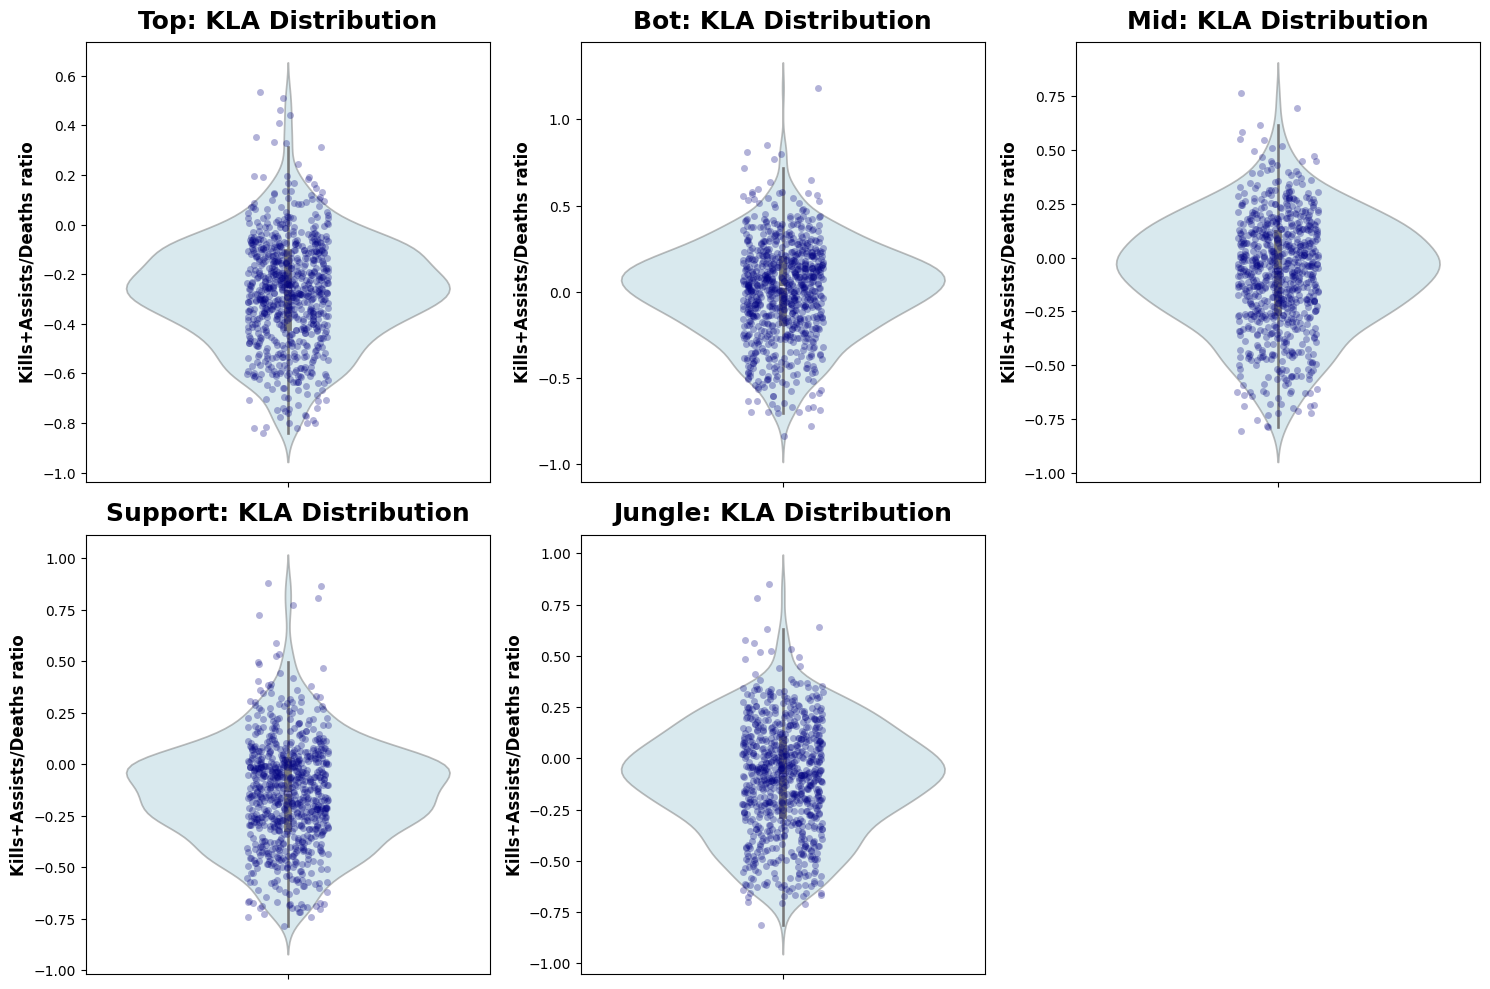

In [42]:
def analyze_raw_stats_importance_by_role(df_players, win_probs_df, enhanced_rankings, min_games=5):
    """
    Analyze which raw player statistics are most important for success in each role.
    
    Args:
        df_players: DataFrame with raw player stats
        win_probs_df: DataFrame with win probabilities
        enhanced_rankings: DataFrame with player skill rankings
        min_games: Minimum games needed for a player to be included
        
    Returns:
        DataFrame with the most important raw statistics by role
    """
    
    # Get useful players data function already converts these stats to per-minute metrics
    useful_columns = [
        'KLA', 'gold_pm', 'lvl_pm', 'creep_score_pm', 'wards_pm',
        'damage_pm', 'damage_to_champions_pm', 'damage_taken_pm',
        'greatest_killing_spree', 'greatest_multi_kill'
    ]
    
    # First, compute average stats per player (useful ones + win related ones + general infos)
    player_stats = []
    
    for player_id, player_games in df_players.groupby('player_id'):
        if len(player_games) < min_games:
            continue
            
        # Get player role (assuming consistent role)
        role = player_games['role'].iloc[0]
        player_name = player_games['player_name'].iloc[0]
        
        # Compute useful stats
        stats_df = get_useful_players_data(player_games)
        
        # Get the mean of each column
        avg_stats = {
            'player_id': player_id,
            'player_name': player_name,
            'role': role,
            'num_games': len(player_games),
            'win_rate': player_games['win'].mean()
        }
        
        # Add each stat average
        for col in useful_columns:
            avg_stats[f'avg_{col}'] = stats_df[col].mean()
            
        player_stats.append(avg_stats)
    
    # Convert to DataFrame
    player_raw_stats = pd.DataFrame(player_stats)
    
    # Merge with enhanced rankings to get skill score
    if 'player_id' in enhanced_rankings.columns:
        player_raw_stats = player_raw_stats.merge(
            enhanced_rankings[['player_id', 'skill_score', 'skill_rank']], 
            on='player_id', 
            how='left'
        )
    
    # Analyze importance by role
    role_importance = {}
    
    for role in player_raw_stats['role'].unique():
        role_df = player_raw_stats[player_raw_stats['role'] == role].copy()
        
        # Skip if too few players
        if len(role_df) < 10:
            continue
            
        # Calculate correlation of raw stats with skill score
        correlations = []
        for feature in [f'avg_{col}' for col in useful_columns]:
            if feature in role_df.columns:
                valid_mask = role_df[feature].notnull()
                if valid_mask.sum() > 5:
                    # Calculate correlation with skill score
                    # corr = role_df.loc[valid_mask, [feature, 'skill_score']].corr().iloc[0, 1]
                    
                    # Calculate correlation with win rate
                    corr = role_df.loc[valid_mask, [feature, 'win_rate']].corr().iloc[0, 1]
                    correlations.append((feature.replace('avg_', ''), abs(corr)))
        
        # Sort by correlation strength
        correlations.sort(key=lambda x: x[1], reverse=True)
        role_importance[role] = correlations
    
    # Create result table
    results = []
    for role, importances in role_importance.items():
        if importances:
            top_feature, correlation = importances[0]
            
            # Calculate average values by role
            role_players = player_raw_stats[player_raw_stats['role'] == role]
            avg_values = {}
            for feat, _ in importances:
                feat_col = f'avg_{feat}'
                if feat_col in role_players.columns:
                    avg_values[feat] = role_players[feat_col].mean()
            
            results.append({
                'Role': role,
                'Most Important Stat': top_feature,
                'Correlation with Skill': correlation,
                'Avg Value': avg_values.get(top_feature),
                'Top 3 Stats': [feat for feat, _ in importances[:3]],
                'All Stats Ranked': [feat for feat, _ in importances]
            })
    
    return pd.DataFrame(results), player_raw_stats

# Run the analysis
# importance_by_role, player_raw_stats = analyze_raw_stats_importance_by_role(
#     df_game_players_stats, df_win_probs, enhanced_rankings
# )

# Run the analysis with the normalized features
importance_by_role, player_raw_stats = analyze_raw_stats_importance_by_role(
    df_game_players_normalized_features, df_win_probs, enhanced_rankings
)

# Display results in a formatted table
styled_table = importance_by_role[['Role', 'Most Important Stat', 'Correlation with Skill', 'Top 3 Stats']]
styled_table['Correlation with Skill'] = styled_table['Correlation with Skill'].apply(lambda x: f'{x:.3f}')

# Show the results
print("Most Important Raw Statistics By Player Role")
print("-" * 70)
display(styled_table)

# Visualize top stats by role
plt.figure(figsize=(14, 9))
role_labels = []

for i, (_, row) in enumerate(importance_by_role.iterrows()):
    stats = row['All Stats Ranked']
    role_labels.append(row['Role'])
    
    # Plot the top 5 stats with diminishing size to indicate rank
    for j, stat in enumerate(stats[:5]):
        size = max(180 * (5 - j) / 5, 40)  # Minimum size of 40
        alpha = max(1.0 * (5 - j) / 5, 0.4)  # Minimum alpha of 0.4
        color = plt.cm.tab10(j / 5)  # Different color for each stat
        
        plt.scatter(i, j, s=size, alpha=alpha, color=color, 
                   label=stat if i == 0 else "")
        plt.text(i, j, stat, ha='center', va='center', fontsize=9, 
                color='white' if alpha > 0.6 else 'black')

plt.yticks(range(5), ['1st', '2nd', '3rd', '4th', '5th'])
plt.xticks(range(len(role_labels)), role_labels)
plt.ylabel('Importance Rank')
plt.xlabel('Player Role')
plt.title('Most Important Raw Statistics by Player Role', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.3)

# Add a legend mapping stats to descriptions
stat_descriptions = {
    'KLA': 'Kills+Assists/Deaths ratio',
    'gold_pm': 'Gold per minute',
    'lvl_pm': 'Level per minute',
    'creep_score_pm': 'CS per minute',
    'wards_pm': 'Wards placed per minute',
    'damage_pm': 'Total damage per minute',
    'damage_to_champions_pm': 'Champion damage per minute',
    'damage_taken_pm': 'Damage taken per minute',
    'greatest_killing_spree': 'Longest killing spree',
    'greatest_multi_kill': 'Largest multi-kill'
}

# Add stat descriptions as a text box
desc_text = "\n".join([f"{stat}: {desc}" for stat, desc in stat_descriptions.items()])
plt.figtext(0.01, 0.01, desc_text, fontsize=9, wrap=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for the descriptions
plt.show()

# Show average stat values by role
role_avg_stats = player_raw_stats.groupby('role').agg({
    col: 'mean' for col in player_raw_stats.columns if col.startswith('avg_')
}).reset_index()

# Format for display
display_stats = role_avg_stats.copy()
# Rename columns for clarity
display_stats.columns = [col.replace('avg_', '') if col != 'role' else col for col in display_stats.columns]
print("\nAverage Raw Statistics By Role")
print("-" * 70)
display(display_stats.round(3))

# Create boxplots for the top stat by role
plt.figure(figsize=(15, 10))
for i, (_, row) in enumerate(importance_by_role.iterrows()):
    role = row['Role']
    top_stat = f"avg_{row['Most Important Stat']}"
    
    if i < len(importance_by_role):
        plt.subplot(2, 3, i+1)
        role_data = player_raw_stats[player_raw_stats['role'] == role]
        
        # Create violin plot with individual points
        sns.violinplot(y=role_data[top_stat], color="lightblue", alpha=0.5)
        sns.stripplot(y=role_data[top_stat], color="navy", alpha=0.3, size=5)
        
        plt.title(f"{role}: {row['Most Important Stat']} Distribution")
        plt.ylabel(stat_descriptions.get(row['Most Important Stat'], row['Most Important Stat']))

plt.tight_layout()
plt.show()

### We can now say that KLA is the most important stat that a player can increase
Additionnally we can see that the distribution of the KLA is following a quasi-gaussian curve

## Choose the best team composition

Our skill ranking system is not very good at determining real-world rankings, but with it we can create the best team according to our computation


In [43]:
def get_top_5_best_players(rankings_df, importance_by_role=None, player_raw_stats=None):
    """
    Get the top player from each role according to skill rankings,
    and include the actual values of their top 3 important stats.
    
    Args:
        rankings_df: DataFrame with enhanced player rankings
        importance_by_role: DataFrame with information about important stats by role
        player_raw_stats: DataFrame with raw player statistics
        
    Returns:
        DataFrame with the top player from each role and their important stat values
    """
    # Initialize a DataFrame to store the best players
    best_players = pd.DataFrame()
    
    # Get the top player for each role
    for role in ['Top', 'Jungle', 'Mid', 'Bot', 'Support']:
        role_players = rankings_df[rankings_df['role'] == role]
        if not role_players.empty:
            # Get the player with the lowest skill_rank (highest ranking)
            best_player = role_players.sort_values('skill_rank').iloc[0:1]
            
            # Add top 3 important stats for this role if available
            if importance_by_role is not None and player_raw_stats is not None:
                role_stats = importance_by_role[importance_by_role['Role'] == role]
                if not role_stats.empty:
                    top_stats = role_stats.iloc[0]['Top 3 Stats']
                    
                    # Get player data
                    player_id = best_player['player_id'].values[0]
                    player_data = player_raw_stats[player_raw_stats['player_id'] == player_id]
                    
                    if not player_data.empty:
                        for i, stat in enumerate(top_stats[:3], 1):
                            stat_col = f'avg_{stat}'
                            if stat_col in player_data.columns:
                                stat_value = player_data[stat_col].values[0]
                                best_player[f'Important Stat {i}'] = f"{stat}: {stat_value:.2f}"
            
            best_players = pd.concat([best_players, best_player])
    
    # Sort by skill_rank for display
    best_players = best_players.sort_values('skill_rank')
    
    return best_players

# Get the top 5 players with their important stat values
top_5_team = get_top_5_best_players(enhanced_rankings, importance_by_role, player_raw_stats)

# Custom display function with additional columns
def display_enhanced_rankings_with_stats(rankings, top_n=40):
    """
    Display enhanced rankings with clear region and meta score information,
    including important stats and their values.
    """
    display_cols = [
        'skill_rank', 'player_name', 'role', 'region', 
        'region_strength', 'Important Stat 1', 'Important Stat 2', 'Important Stat 3',
        'skill_score', 'num_games', 'avg_win_probability', 'actual_win_rate'
    ]
    
    # Keep only columns that exist in the DataFrame
    display_cols = [col for col in display_cols if col in rankings.columns]
    
    # Format the output
    display_df = rankings[display_cols].head(top_n).copy()
    
    # Add rank column prefix
    display_df['skill_rank'] = display_df['skill_rank'].apply(lambda x: f"#{int(x)}")
    
    # Format percentages
    for col in ['skill_score', 'avg_win_probability', 'actual_win_rate']:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.3f}" if pd.notnull(x) else "N/A")
            
    # Format region strength
    if 'region_strength' in display_df.columns:
        display_df['region_strength'] = display_df['region_strength'].apply(
            lambda x: f"{x:.2f}x" if pd.notnull(x) else "N/A"
        )
    
    return display_df.set_index('skill_rank')

# Display the results with important stat values
display_enhanced_rankings_with_stats(top_5_team, top_n=5)

,player_name,role,region,region_strength,Important Stat 1,Important Stat 2,Important Stat 3,skill_score,num_games,avg_win_probability,actual_win_rate
skill_rank,,,,,,,,,,,
#1,Nanaue,Top,Vietnam,0.86x,KLA: -0.33,greatest_killing_spree: 0.18,gold_pm: 0.49,0.941,42,0.630,0.738
#2,LYONZ,Bot,Latin America,0.73x,KLA: 0.28,greatest_killing_spree: -0.62,gold_pm: -1.13,0.928,188,0.648,0.713
#4,Qats,Mid,Brazil,0.84x,KLA: 0.06,greatest_killing_spree: 0.33,gold_pm: 0.46,0.918,161,0.609,0.677
#9,Nerzhul,Support,Europe,0.95x,KLA: 0.53,gold_pm: -1.20,wards_pm: 1.72,0.904,34,0.748,0.853
#13,sarolu,Jungle,Brazil,0.84x,KLA: 0.14,greatest_killing_spree: -0.15,gold_pm: -0.09,0.893,32,0.649,0.750


This ranking is obviously false but we can see that they all have in common a high actual win rate (we can hope that together they can keep it high, even with the language barrier)